# DS 5001 Project Notebook: Greek and Roman Mythology

- David Vann (dv6bq@virginia.edu)
- DS 5001
- 5 May 2021

The code used for processing the files and working on them is available in the `eta_modules` folder to separate most of the implementation details from the presentation of results. I try to show additional relevant functionality beyond pure results to give a better indication of the process of arriving at these results.

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import nltk

from eta_modules.preprocessing import Document, Corpus
from eta_modules.analysis import HierarchicalClusterAnalysis, PCA, TopicModel, WordEmbedding, SentimentAnalysis

C:\Users\David\miniconda3\envs\ds\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

## Reading in the data

We start by loading in the XML files for each work and parsing them to a reasonable degree with BeautifulSoup and NLTK. 

Since these works are all either plays or poems/epics, the concept of a "chapter" or "paragraph" doesn't translate perfectly compared to, e.g., a novel. However, the Perseus Digital Library (where these files are sourced from) has added at least top-level divisions to break up texts. In some cases, these divisions truly exist in the text (for example, *The Iliad* is broken into 24 books); in other cases, like plays, these divisions don't seem to be directly present in the text, but are akin to something like a "scene". I've considered all of these largest divisions as "chapters".

To get at something like a "paragraph", I used a different approach based on whether the work was a play or not:

- For plays, I used each speaker section (denoted by a "\<sp>" in the files) as a "paragraph". 
- For everything else, there wasn't a built-in tag for "paragraph"-type divisions, but there is a self-closing "milestone" tag that marks the start of a new "card" used on the Perseus website to denote content to be displayed on one page. Since these are self-closing, they don't actually enclose the particular block of text that I wanted to get at; instead, I replaced these with newlines and split up text based on a double newline, which seemed to give fairly satisfactory results.

I've included code/functions that are able to either parse the XML files from their initial state or load in pre-computed Corpus tables to speed up notebook computations.

In [3]:
def parse_corpus(docpaths, tfidf_bag=['work_id', 'chapter_id'], tfidf_methods=['n', 'max', 'bool']):
    doc_list = []
    for path in docpaths:
        doc = Document(path)
        doc.parse_text_to_paras()
        doc.tokenize(remove_pos_tuple=True, remove_ws=True)
        doc_list.append(doc)

    corpus = Corpus(doc_list)
    corpus.extract_annotate_vocab()
    corpus.compute_tfidf(OHCO_level=tfidf_bag, methods=tfidf_methods)
    
    return doc_list, corpus


# Annotating the vocabulary uses NLTK and is slow since it's not a vectorized operation, so it's much faster to reload the tables if they already exist
# Still recompute TFIDF since bags/methods can differ between calculations
def load_corpus(docpaths=None, table_dir=None, tfidf_bag=['work_id', 'chapter_id'], tfidf_methods=['n', 'max', 'bool']):
    if table_dir is not None:
        corpus_filepaths = glob(os.path.join(table_dir, '*.csv'))
        if len(corpus_filepaths) != 0:
            corpus = Corpus()
            corpus.load_tables(table_dir)
            corpus.compute_tfidf(OHCO_level=tfidf_bag, methods=tfidf_methods)
            output = ([], corpus)
    elif docpaths is not None:
        doc_list, corpus = parse_corpus(docpaths=docpaths, tfidf_bag=tfidf_bag, tfidf_methods=tfidf_methods)
        output = (doc_list, corpus)
    
    return output

In [4]:
root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data')

# Make output directory if it does not exist
output_dir = os.path.join(data_dir, 'outputs')
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

docpaths = glob(os.path.join(data_dir, 'raw', '**', '*.xml'), recursive=True) # Get all XML file paths
table_dir = os.path.join(output_dir, 'corpus')

OHCO = ['work_id', 'chapter_id', 'para_id', 'sent_id']
book_bag = OHCO[:1]
chapter_bag = OHCO[:2]
paragraph_bag = OHCO[:3]

In [5]:
# Load in pre-existing tables
# doc_list, corp = load_corpus(table_dir=table_dir, tfidf_bag=chapter_bag) # doc_list is empty here, but it's not important for any further analyses; it's mostly useful for printing out sections of text (if you so desired)

# Parse from scratch
doc_list, corp = load_corpus(docpaths=docpaths, tfidf_bag=chapter_bag)

In [6]:
corp.lib

author               title  \
work_id                                      
0            Aeschylus           Agamemnon   
1            Aeschylus           Eumenides   
2            Aeschylus    Libation Bearers   
3            Aeschylus    Prometheus Bound   
4            Euripides             Bacchae   
5            Euripides  Iphigenia in Aulis   
6            Euripides    The Trojan Women   
7               Hesiod            Theogony   
8               Hesiod      Works and Days   
9                Homer               Iliad   
10               Homer             Odyssey   
11       Homeric_Hymns       Homeric Hymns   
12                Ovid       Metamorphoses   
13           Sophocles                Ajax   
14           Sophocles            Antigone   
15           Sophocles             Electra   
16           Sophocles  Oedipus at Colonus   
17           Sophocles    Oedipus Tyrannus   
18              Vergil              Aeneid   

                                                      path  
work_id                                                     
0        C:\Users\David\Documents\GitHub\latin-greek-te...  
1        C:\Users\David\Documents\GitHub\latin-greek-te...  
2        C:\Users\David\Documents\GitHub\latin-greek-te...  
3        C:\Users\David\Documents\GitHub\latin-greek-te...  
4        C:\Users\David\Documents\GitHub\latin-greek-te...  
5        C:\Users\David\Documents\GitHub\latin-greek-te...  
6        C:\Users\David\Documents\GitHub\latin-greek-te...  
7        C:\Users\David\Documents\GitHub\latin-greek-te...  
8        C:\Users\David\Documents\GitHub\latin-greek-te...  
9        C:\Users\David\Documents\GitHub\latin-greek-te...  
10       C:\Users\David\Documents\GitHub\latin-greek-te...  
11       C:\Users\David\Documents\GitHub\latin-greek-te...  
12       C:\Users\David\Documents\GitHub\latin-greek-te...  
13       C:\Users\David\Documents\GitHub\latin-greek-te...  
14       C:\Users\David\Documents\GitHub\latin-greek-te...  
15       C:\Users\David\Documents\GitHub\latin-greek-te...  
16       C:\Users\David\Documents\GitHub\latin-greek-te...  
17       C:\Users\David\Documents\GitHub\latin-greek-te...  
18       C:\Users\David\Documents\GitHub\latin-greek-te...

In [7]:
corp.token

pos  token_str  term_str
work_id chapter_id para_id sent_id token_id                          
0       0          0       0       0         NNP  Watchman:  watchman
                                   1         NNP    Release   release
                                   2          IN       from      from
                                   3          DT       this      this
                                   4          JJ      weary     weary
...                                          ...        ...       ...
18      11         29      13      14         NN      wrath     wrath
                                   15         TO         to        to
                                   16         VB   darkness  darkness
                                   17         JJ       fled      fled
                                   18         NN      away.      away

[740470 rows x 3 columns]

### Term frequency methods used in this notebook

- `n`: raw sum of term occurrences within a document (a document can be a book, chapter, paragraph, etc., depending on the chosen bag)
- `max`: Maximum term frequency normalization: $tf_{t,d} = 0.4 + 0.6 \frac{tf_{t,d}}{tf_{max}(d)}$; divide raw count of term in document by raw count of most frequent term in a document. This can help prevent bias towards longer documents
- `bool`: binary frequencies; term either does or does not occur in document

A chapter-level bag tends to give more significant nouns, while a paragraph-level bag or smaller will likely result in more terms like pronouns being significant.

In [8]:
corp.vocab.sort_values('tfidf_bool_sum', ascending=False).head(10)

n  stop p_stem pos_max   df       idf  tfidf_n_sum  \
term_str                                                          
sing        87     0   sing     VBG   58  2.208108     1.816905   
hail        96     0   hail     NNP   66  2.021695     1.835607   
song       172     0   song      NN   81  1.726239     2.808162   
begin       51     0  begin      VB   38  2.818162     1.359342   
chorus     841     0  choru     NNP  138  0.957565     7.616525   
zeus      1270     0    zeu     NNP  170  0.656698     7.887916   
muse        22     0   muse     NNP   18  3.896164     0.810686   
lovely     152     0   love      JJ   53  2.338169     3.361338   
bare       173     0   bare      NN   63  2.088809     3.417729   
lord       380     0   lord      NN  149  0.846921     3.043821   

          tfidf_max_sum  tfidf_bool_sum  
term_str                                 
sing           4.661218       20.941718  
hail           4.764603       18.136252  
song           5.019914       15.020710  
begin          3.795364       13.793796  
chorus         5.562277       12.176520  
zeus           4.092533        9.574987  
muse           2.520064        9.125414  
lovely         4.336112        8.647434  
bare           4.530909        8.549576  
lord           4.374682        8.539977

## Hierarchical Clustering based on TF-IDF (max normalization)

Basic process:

- Recalculate TF-IDF (using maximum normalization of term frequencies) if it doesn't already exist in the table for the particular bag used
- Filter vocab to some `max_features`-long subset using DF-IDF (document frequency * inverse-document frequency -- works as a measure of global term significance)
- Get average TF-IDF values for each term by work (`hca.tfidf`)
- Get pairwise distances between these word vectors using some metric (here, we use `cosine`, and `jaccard`)
  - Cosine similarty gets the angle between two vectors. It is between 0 and 1, with 0 indicating two orthogonal (unrelated) vectors and 1 indicating two collinear (highly related, presumably) vectors.
  - Jaccard similarity uses binary values for TF-IDF (present/not present) and is the proportion of elements that agree between two vectors.
  - Cosine distance/Jaccard distance = 1 - cosine similarity/Jaccard similarity (this is what is actually used for constructing dendrograms)

In [9]:
hca = HierarchicalClusterAnalysis(max_features=6000, tfidf_method='max', OHCO_level=chapter_bag)
hca.fit(corp, metrics=['cosine', 'jaccard'])

In [10]:
hca.tfidf.shape

(19, 6000)

In [11]:
hca.tfidf.head()

term_str    escape    course      deed      wise      days     truth  \
work_id                                                                
0         0.157268  0.198696  0.328274  0.117703  0.206300  0.239128   
1         0.146918  0.100943  0.199575  0.049453  0.048562  0.051170   
2         0.219391  0.274928  0.337530  0.000000  0.106757  0.273227   
3         0.232349  0.220720  0.107114  0.108874  0.052857  0.231516   
4         0.091184  0.136879  0.091675  0.233985  0.000000  0.045688   

term_str   nothing     tears     ships      hope  ...   cleared  existence  \
work_id                                           ...                        
0         0.204890  0.359166  0.158842  0.248154  ...  0.000000        0.0   
1         0.251594  0.049749  0.000000  0.000000  ...  0.000000        0.0   
2         0.108723  0.165983  0.000000  0.219631  ...  0.000000        0.0   
3         0.278479  0.149096  0.053396  0.053862  ...  0.207856        0.0   
4         0.090815  0.093825  0.000000  0.091845  ...  0.000000        0.0   

term_str  wreak  smithy  shadowed  chords  corded    dreary   flashes  muscles  
work_id                                                                         
0           0.0     0.0       0.0     0.0     0.0  0.000000  0.000000      0.0  
1           0.0     0.0       0.0     0.0     0.0  0.000000  0.000000      0.0  
2           0.0     0.0       0.0     0.0     0.0  0.000000  0.000000      0.0  
3           0.0     0.0       0.0     0.0     0.0  0.203409  0.203525      0.0  
4           0.0     0.0       0.0     0.0     0.0  0.000000  0.000000      0.0  

[5 rows x 6000 columns]

In [12]:
# TF-IDF values used for Jaccard
hca.tfidf.astype('bool').astype('int').head()

term_str  escape  course  deed  wise  days  truth  nothing  tears  ships  \
work_id                                                                    
0              1       1     1     1     1      1        1      1      1   
1              1       1     1     1     1      1        1      1      0   
2              1       1     1     0     1      1        1      1      0   
3              1       1     1     1     1      1        1      1      1   
4              1       1     1     1     0      1        1      1      0   

term_str  hope  ...  cleared  existence  wreak  smithy  shadowed  chords  \
work_id         ...                                                        
0            1  ...        0          0      0       0         0       0   
1            0  ...        0          0      0       0         0       0   
2            1  ...        0          0      0       0         0       0   
3            1  ...        1          0      0       0         0       0   
4            1  ...        0          0      0       0         0       0   

term_str  corded  dreary  flashes  muscles  
work_id                                     
0              0       0        0        0  
1              0       0        0        0  
2              0       0        0        0  
3              0       1        1        0  
4              0       0        0        0  

[5 rows x 6000 columns]

### Dendrograms

Overall, both metrics lead to fairly good segmentation, both by author and between plays (Aeschylus, Sophocles, and Euripides) vs. non-plays. Additionally, with both metrics, both of the Roman works (by Vergil and Ovid) have a high degree of similarity to each other, and they are also grouped together with both of Homer's works, which likely indicates some artistic influence. The *Aeneid* certainly takes inspiration from the *Iliad* and the *Odyssey*.

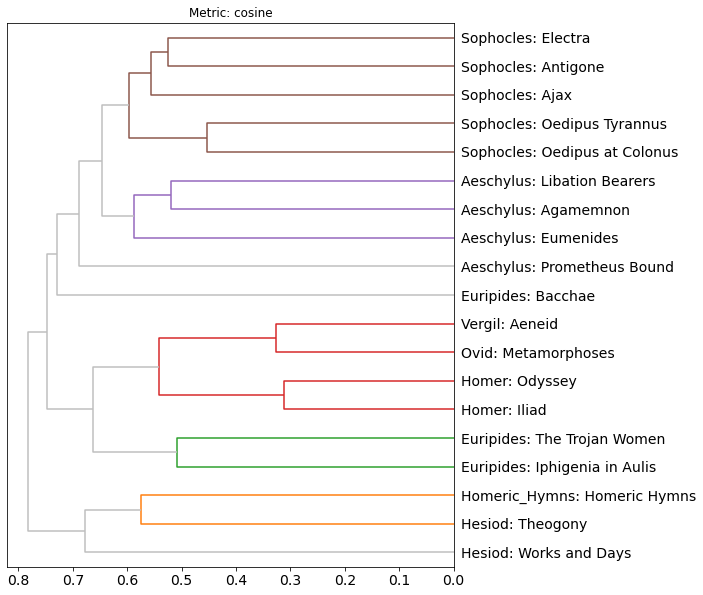

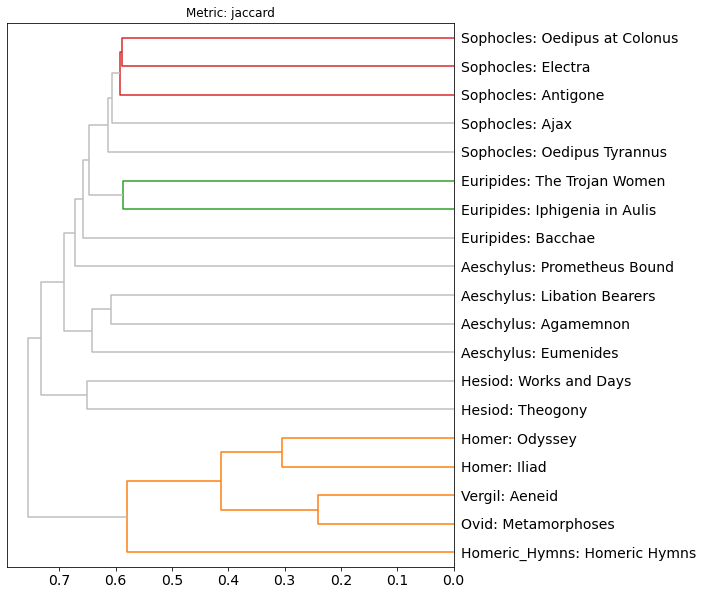

In [13]:
hca.plot_dendrogram(linkage='complete', color_thresh=0.6, figsize=(8, 10))

## Principal Components Analysis using TF-IDF covariance matrix

Basic process:

- Recalculate TF-IDF and filter based on DF-IDF, similar to hierarchical clustering
- Take TF-IDF averages by term based on documents (in this case, "chapters" in each work)
- L2-normalize TF-IDF values by document (longer documents/chapters shouldn't be more influential)
- Center word vectors by subtracting mean
- Calculate covariance matrix for TF-IDF values (`max_features` x `max_features` matrix)
- Compute eigendecomposition of covariance matrix into eigenvectors and eigenvalues
- Project TF-IDF values onto subset of eigenvectors that explain the highest proportion of variance in the data (e.g, 2 for plotting) to produce a new representation of data

In [14]:
pca = PCA(max_features=6000, tfidf_method='max', OHCO_level=chapter_bag)
pca.fit(corp, n_components=10)

In [15]:
pca.dcm

pc_id                              PC0       PC1       PC2       PC3  \
author    work_id chapter_id                                           
Aeschylus 0       0           0.057497 -0.013661  0.010521  0.053873   
                  1           0.053718 -0.018887  0.016128  0.036141   
                  2           0.043588 -0.034729 -0.002787  0.036574   
                  3           0.071665 -0.019244 -0.021010  0.024067   
                  4           0.023816 -0.068131 -0.086996  0.002716   
...                                ...       ...       ...       ...   
Vergil    18      7          -0.251425 -0.298854  0.219959  0.037499   
                  8          -0.277723 -0.281795  0.191773  0.093623   
                  9          -0.278448 -0.303302  0.193671  0.100347   
                  10         -0.267634 -0.314467  0.163282  0.092486   
                  11         -0.289986 -0.299875  0.170745  0.101264   

pc_id                              PC4       PC5       PC6       PC7  \
author    work_id chapter_id                                           
Aeschylus 0       0          -0.075172  0.077731  0.047608  0.047069   
                  1          -0.053561  0.086005  0.027213  0.035085   
                  2          -0.070483  0.108517  0.053821  0.057228   
                  3          -0.063857  0.033064  0.065676  0.084621   
                  4          -0.069921  0.112674 -0.006328  0.022679   
...                                ...       ...       ...       ...   
Vergil    18      7          -0.105356 -0.022902  0.163190 -0.116983   
                  8          -0.115714 -0.001080  0.136849 -0.144259   
                  9          -0.149359 -0.001530  0.161956 -0.153768   
                  10         -0.119070 -0.000040  0.167748 -0.133087   
                  11         -0.126053 -0.040280  0.146078 -0.138442   

pc_id                              PC8       PC9  
author    work_id chapter_id                      
Aeschylus 0       0          -0.011809 -0.000315  
                  1          -0.026227  0.051715  
                  2          -0.057343  0.039432  
                  3          -0.026635  0.041619  
                  4          -0.062630  0.018398  
...                                ...       ...  
Vergil    18      7          -0.095848 -0.087087  
                  8          -0.072943 -0.122531  
                  9          -0.074974 -0.104072  
                  10         -0.094929 -0.122952  
                  11         -0.100881 -0.096678  

[268 rows x 10 columns]

In [16]:
pca.loadings

pc_id          PC0       PC1       PC2       PC3       PC4       PC5  \
term_str                                                               
escape   -0.010120 -0.002449 -0.027795  0.005076  0.004283 -0.004381   
course   -0.008573 -0.011078 -0.017529 -0.002960 -0.007751  0.008520   
deed      0.000557 -0.011832 -0.031021  0.001822 -0.006226 -0.015055   
wise     -0.015591  0.017736 -0.003561 -0.012605  0.016556  0.004607   
days     -0.014480 -0.005263 -0.020372 -0.011556 -0.013908  0.000277   
...            ...       ...       ...       ...       ...       ...   
chords   -0.005593 -0.001430 -0.005340 -0.016261 -0.006412 -0.002907   
corded   -0.011193  0.010994 -0.006903 -0.018157 -0.005729  0.000658   
dreary   -0.002619 -0.011666  0.003299  0.001401 -0.000670  0.004587   
flashes   0.002311 -0.005922 -0.004316  0.004263 -0.007960 -0.016765   
muscles  -0.006407 -0.010455  0.004431  0.000872  0.006983 -0.005453   

pc_id          PC6       PC7       PC8       PC9  
term_str                                          
escape   -0.005445  0.008432 -0.009285  0.008761  
course    0.009102  0.006608  0.001857  0.014243  
deed     -0.004993  0.002886 -0.032243  0.008116  
wise      0.001657 -0.012111 -0.010527 -0.004924  
days      0.000018 -0.002721  0.002265  0.006737  
...            ...       ...       ...       ...  
chords   -0.002382  0.008008 -0.005154 -0.004271  
corded    0.009186  0.001171 -0.000573 -0.000514  
dreary   -0.001726  0.002471  0.009122  0.012241  
flashes   0.002202 -0.025626  0.003306  0.002177  
muscles  -0.014534  0.011424  0.007463  0.009662  

[6000 rows x 10 columns]

### PCA plots

- Principal Component 0 (PC0) seems to provide a relatively good separation between plays and non-plays (Homeric Hymns are an exception, they're clustered quite close to the plays)
- Principal Component 1 (PC1) separates clearly the later Roman works from the Greek works.
- Not entirely clear what element of the corpus PC2 is pulling out, if anything

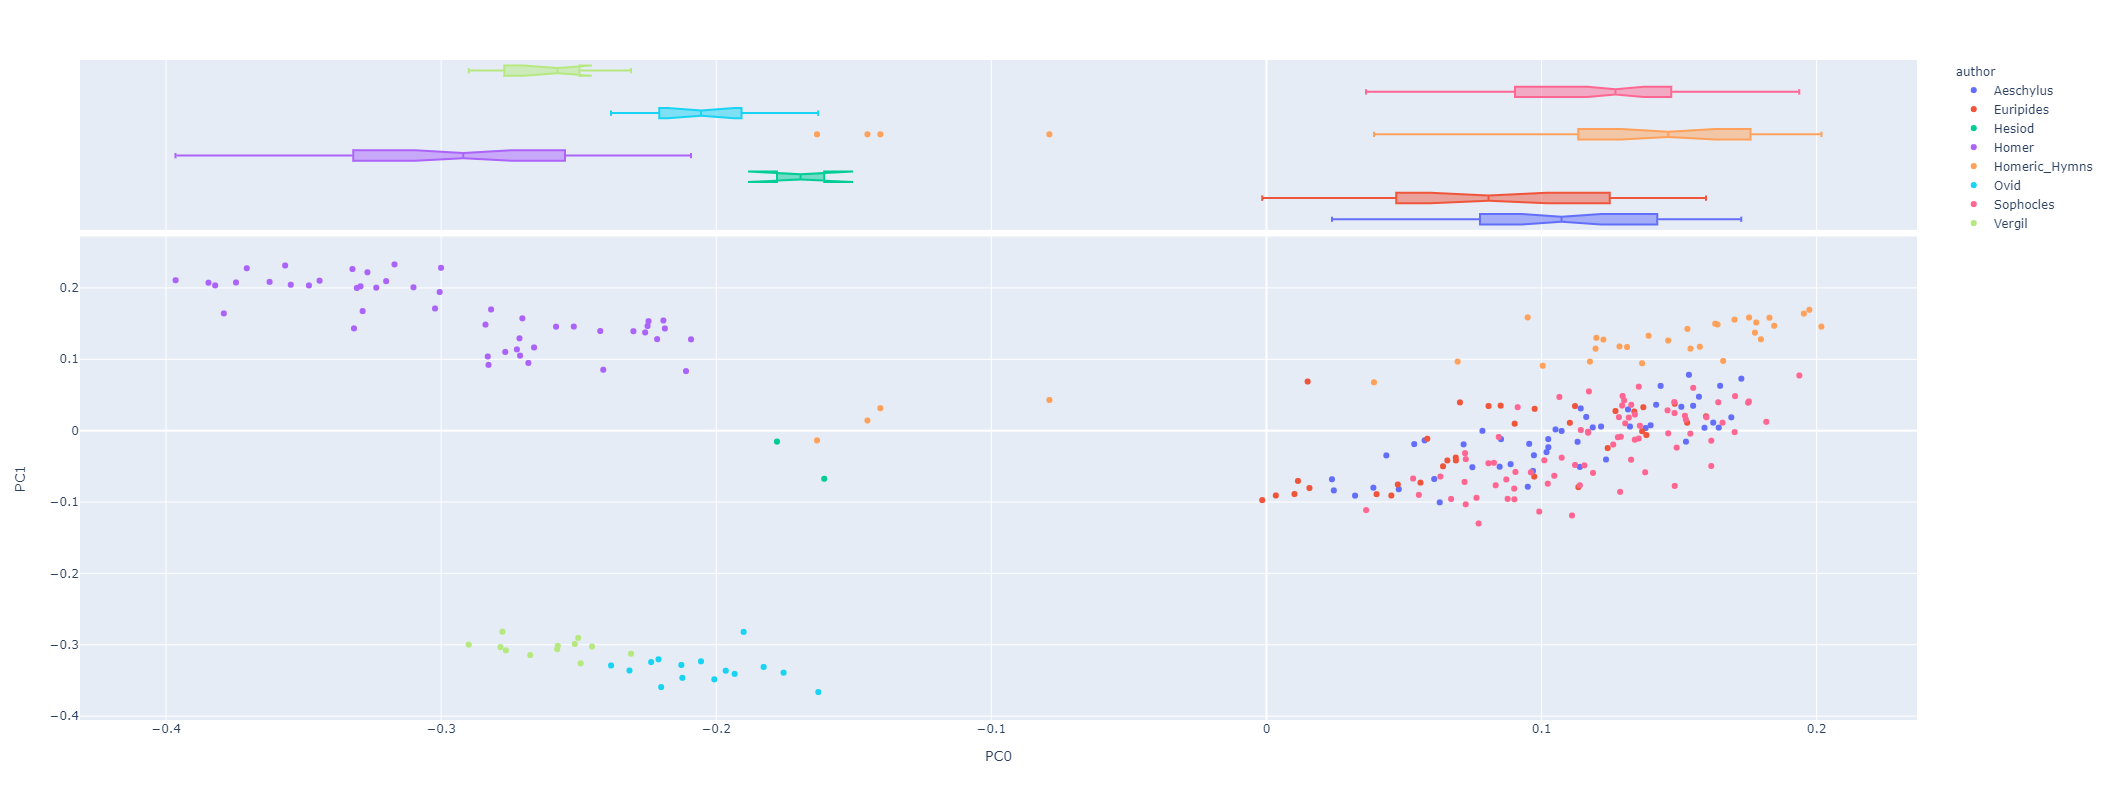

In [17]:
pca.plot_2d(comp_id_1=0, comp_id_2=1)

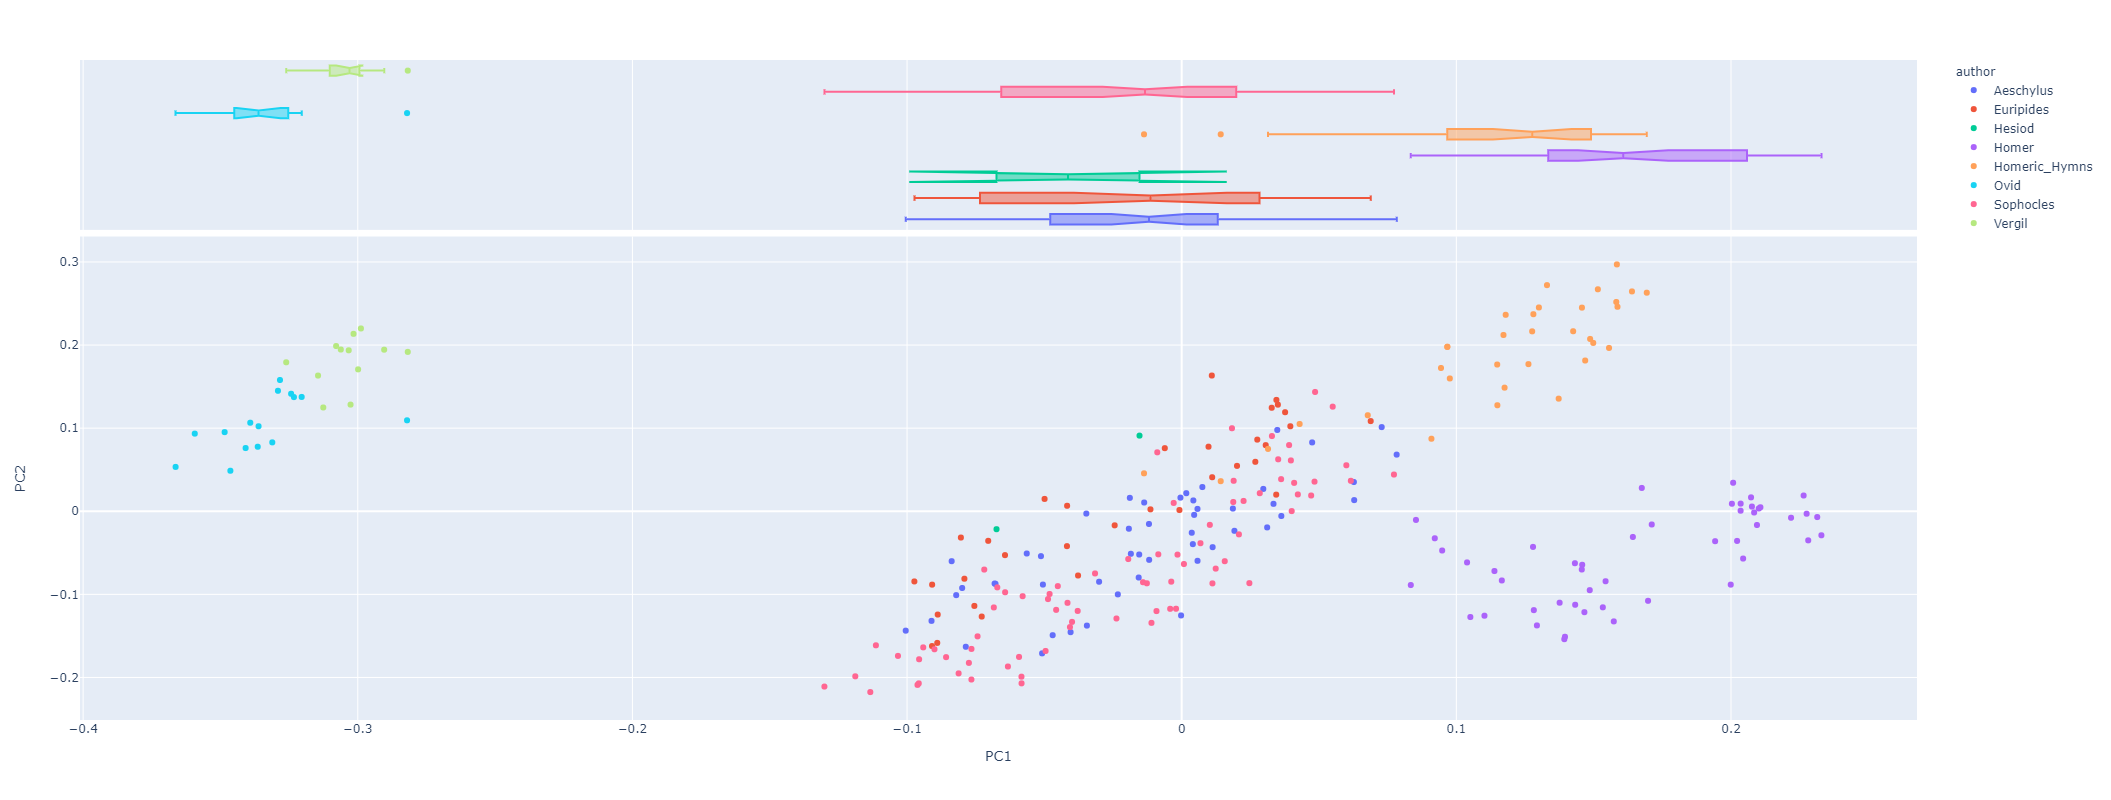

In [18]:
pca.plot_2d(comp_id_1=1, comp_id_2=2)

## Topic Models (LDA)

Topic models can provide an interpretable, high-level model for the patterns and themes of documents. The main outputs of a Latent Dirichlet Allocation (LDA) model are a $\theta$ and $\phi$ table.

- $\theta$ - Document-topic table; probability distribution of documents over topics
- $\phi$ - Topic-word table; probability distribution of topics over words

Some additional details are available from the [scikit-learn website](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) or [Wikipedia](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

In [19]:
lda = TopicModel(remove_proper_nouns=True, max_features=6000, max_iter=25, n_topics=40, random_state=0)
lda.fit(corp)

In [20]:
lda.theta

topic_id                  0         1         2         3         4   \
work_id chapter_id                                                     
0       0           0.000135  0.000135  0.000135  0.000135  0.000135   
        1           0.000106  0.000106  0.000106  0.000106  0.000106   
        2           0.000133  0.000133  0.000133  0.072866  0.000133   
        3           0.000133  0.000133  0.000133  0.000133  0.000133   
        4           0.000068  0.000068  0.000068  0.048339  0.000068   
...                      ...       ...       ...       ...       ...   
18      7           0.000013  0.000013  0.000013  0.418549  0.000013   
        8           0.000012  0.000012  0.000012  0.662574  0.000012   
        9           0.000011  0.000011  0.000011  0.491197  0.000011   
        10          0.000010  0.000010  0.000010  0.692856  0.000010   
        11          0.000010  0.000010  0.000010  0.614628  0.000010   

topic_id                  5         6         7         8         9   ...  \
work_id chapter_id                                                    ...   
0       0           0.000135  0.000135  0.000135  0.000135  0.000135  ...   
        1           0.000106  0.040322  0.000106  0.416396  0.000106  ...   
        2           0.000133  0.000133  0.000133  0.457596  0.000133  ...   
        3           0.000133  0.000133  0.000133  0.000133  0.000133  ...   
        4           0.000068  0.000068  0.000068  0.499722  0.000068  ...   
...                      ...       ...       ...       ...       ...  ...   
18      7           0.000013  0.000013  0.000013  0.039973  0.000013  ...   
        8           0.000012  0.000012  0.000012  0.059953  0.000012  ...   
        9           0.000011  0.000011  0.000011  0.046431  0.000011  ...   
        10          0.000010  0.000010  0.000010  0.105097  0.000010  ...   
        11          0.000010  0.000010  0.000010  0.052493  0.000010  ...   

topic_id                  30        31        32        33        34  \
work_id chapter_id                                                     
0       0           0.000135  0.000135  0.000135  0.000135  0.000135   
        1           0.196527  0.000106  0.000106  0.000106  0.000106   
        2           0.000133  0.000133  0.000133  0.000133  0.000133   
        3           0.000133  0.000133  0.000133  0.000133  0.000133   
        4           0.000068  0.000068  0.148245  0.000068  0.000068   
...                      ...       ...       ...       ...       ...   
18      7           0.000013  0.000013  0.026283  0.000013  0.000013   
        8           0.000012  0.005566  0.011198  0.000012  0.000012   
        9           0.000011  0.197777  0.000011  0.000011  0.000011   
        10          0.000010  0.000010  0.000010  0.000010  0.000010   
        11          0.000010  0.000010  0.000010  0.000010  0.000010   

topic_id                  35        36        37        38        39  
work_id chapter_id                                                    
0       0           0.000135  0.000135  0.000135  0.000135  0.000135  
        1           0.000106  0.000106  0.000106  0.000106  0.000106  
        2           0.000133  0.000133  0.000133  0.000133  0.000133  
        3           0.000133  0.000133  0.000133  0.000133  0.000133  
        4           0.000068  0.000068  0.000068  0.000068  0.000068  
...                      ...       ...       ...       ...       ...  
18      7           0.000013  0.000013  0.000013  0.000013  0.038287  
        8           0.000012  0.000012  0.000012  0.000012  0.077584  
        9           0.000011  0.000011  0.000011  0.000011  0.100956  
        10          0.000010  0.000010  0.000010  0.000010  0.040660  
        11          0.000010  0.000010  0.000010  0.000010  0.088510  

[268 rows x 40 columns]

In [21]:
lda.phi.shape

(40, 6000)

In [22]:
lda.phi.head()

term_str   abide    abides     abode  abodes  abomination  abroad  absence  \
topic_id                                                                     
0         0.0250  0.025000  0.025000   0.025        0.025   0.025    0.025   
1         0.0250  0.025000  0.025000   0.025        0.025   0.025    0.025   
2         0.0250  0.025000  0.025000   0.025        0.025   0.025    0.025   
3         2.7821  4.978934  1.366457   0.025        0.025   0.025    0.025   
4         0.0250  0.025000  0.025000   0.025        0.025   0.025    0.025   

term_str  absent  abundance  abuse  ...  young  younger      youth  \
topic_id                            ...                              
0          0.025      0.025  0.025  ...  0.025    0.025   0.025000   
1          0.025      0.025  0.025  ...  0.025    0.025   0.025000   
2          0.025      0.025  0.025  ...  0.025    0.025   1.025000   
3          0.025      0.025  0.025  ...  0.025    0.025  19.886588   
4          0.025      0.025  0.025  ...  0.025    0.025   0.025000   

term_str  youth death    youths  youths bowls   zeal  zenith  zephyrs   zeus  
topic_id                                                                      
0               0.025  0.025000         0.025  0.025   0.025    0.025  1.025  
1               0.025  0.025000         0.025  0.025   0.025    0.025  0.025  
2               0.025  0.025000         0.025  0.025   0.025    0.025  0.025  
3               0.025  5.507344         0.025  0.025   0.025    0.025  0.025  
4               0.025  0.025000         0.025  0.025   0.025    0.025  0.025  

[5 rows x 6000 columns]

### Top words

The below dataframe presents how often particular words appear in the top 10 words associated with each topic. There are 400 words total (10 words representing each topic x 40 topics), so the `p` column is `n`/400.

In [23]:
lda.get_top_words().head(15)

n       p
man     19  0.0475
gods    18  0.0450
men     15  0.0375
land    14  0.0350
house   14  0.0350
son     13  0.0325
heart   12  0.0300
father   9  0.0225
life     9  0.0225
hand     8  0.0200
city     8  0.0200
way      6  0.0150
sea      6  0.0150
mother   6  0.0150
death    6  0.0150

### Topic weights

Topic weights are calculated as the sum of each topic's column in the $\theta$ table.

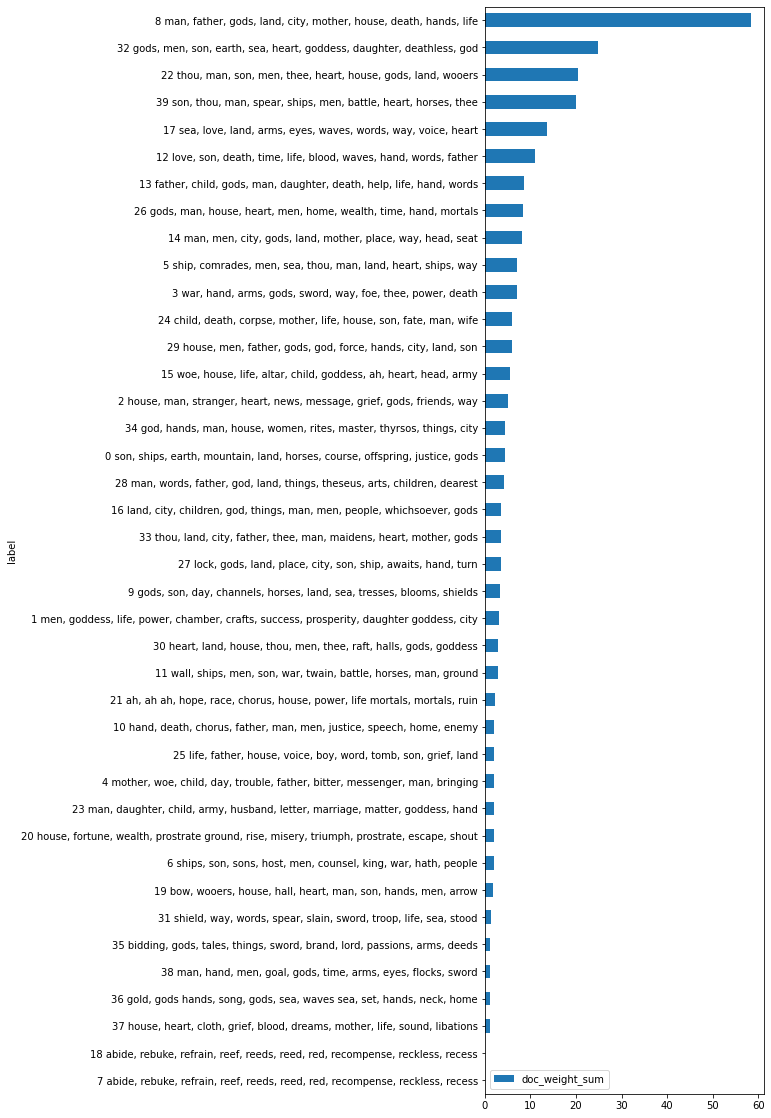

In [24]:
lda.plot_topic_weights()

### Authors and Topics

In this table, you can see which topics are most highly associated with each other. Darker cells indicate topics that are more highly associated with a given author. For example, Vergil (who has a single work in this corpus, the *Aeneid*), is highly associated with the topic that has top terms of "love, son, arms, blood, death, life, words, waves, sea, eyes" and "war, hand, sword, arms, foe, gods, way, thee, shield, spear". Given their equal weights, they could represent the two main sections of the *Aeneid*: the journey by sea to Italy after end of the Trojan War and the battles that took place in Italy after their arrival.

In [25]:
lda.author_topic.style.background_gradient()

## Word Embeddings (word2vec)

Word embedding algorithms produce representative vectors for words based on word co-occurrence statistics in various contexts. So, words which appear in similar contexts (are surrounded by similar words) should have similar vectors.

In [26]:
# Requires gensim v4.0+
w2v = WordEmbedding(OHCO_level=paragraph_bag)
w2v.fit(corp, seed=0, workers=4) # Seed does not guarantee complete reproducibility without some other parameters (e.g., workers=1), but should be more consistent

### 2-dimensional representation of word vectors

- The word vectors generated by the word2vec algorithm have 256 dimensions (can adjust in `fit` method above), but we can visualize them to some degree in 2 dimensions using the [t-distributed stochastic neighor embedding (t-SNE) method](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

Looking through these, it's possible to notice how some related words can cluster together:

- "sea", "ship", "shore", "waves", "ships", "water", "wind", "wave", "earth", "sun", "dark" etc. are all close together -- descriptions of the world
- "head", "shoulders", "hair", "neck", "hand", "blood", "bronze", "spear", "shield" -- descriptions of people, heroes; the armor they wear and weapons they wield

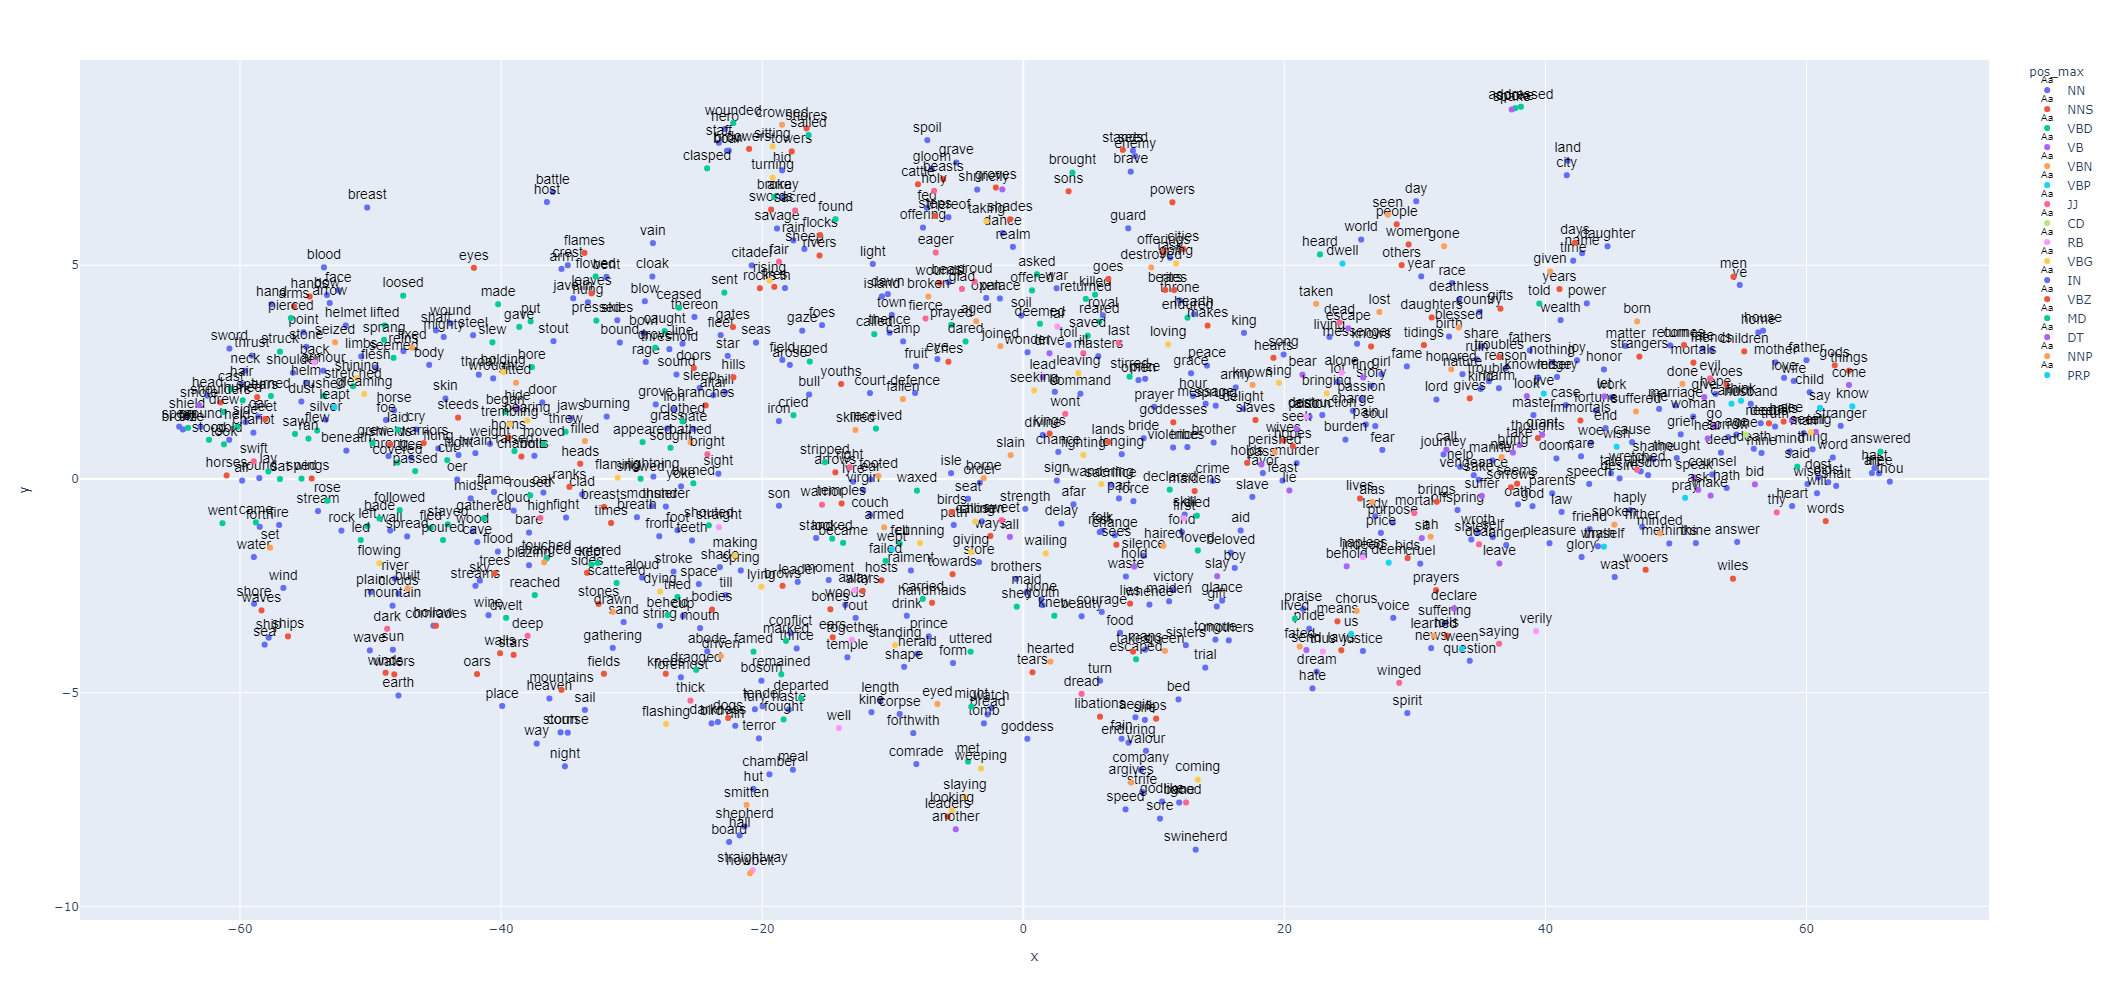

In [27]:
w2v.plot_tsne(random_state=0)

### Word analogies

It's also possible add and subtract word vectors to produce "word analogies" that can sometimes produce interesting results.

In [28]:
w2v.word_analogy('war', 'bronze', 'peace', n=10)

term       sim
0       gold  0.985048
1       held  0.980114
2       head  0.979048
3       took  0.978848
4      smote  0.978692
5     ground  0.978490
6  shoulders  0.977975
7      stood  0.977782
8       fell  0.977330
9       cast  0.977138

In [29]:
w2v.word_analogy('sea', 'death', 'earth', n=10)

term       sim
0     life  0.976423
1    heart  0.973512
2     deed  0.973239
3     mine  0.970396
4    grief  0.970218
5     love  0.969827
6      one  0.968849
7     said  0.966848
8  husband  0.966678
9   answer  0.966468

In [30]:
w2v.word_analogy('sword', 'shield', 'chariot')

term       sim
0     horses  0.996570
1      stood  0.994414
2       gold  0.991702
3       took  0.991255
4        air  0.989980
5       held  0.989638
6      round  0.989574
7       drew  0.989304
8     ground  0.988584
9  shoulders  0.988233

## Sentiment Analysis

The sentiment analysis performed here uses a lexicon-based approach (NRC Emotion Lexicon). 

- Each word in the lexicon is associated with a particular emotional vector
- Words in the lexicon are matched with the corpus vocab (resulting in 2000 "valid" words for determining sentiment)
- This "emotion" vocabulary is applied to terms in each document to generate sentiment values for particular documents (such as chapters or entire works)


In [31]:
nrc_lexicon_path = os.path.join(data_dir, 'lexicons', 'salex_nrc.csv')
sa = SentimentAnalysis(nrc_lexicon_path)
sa.fit(corp)

In [32]:
sa.vocab

n  stop    p_stem pos_max   df       idf  tfidf_n_sum  \
term_str                                                              
god         843     0       god      NN  166  0.691050     5.509721   
death       771     0     death      NN  154  0.799303     5.828521   
words       751     0      word     NNS  159  0.753206     5.349911   
spear       705     0     spear      NN   92  1.542527    10.285246   
war         660     0       war      NN   91  1.558295     9.727163   
...         ...   ...       ...     ...  ...       ...          ...   
raid          1     0      raid      NN    1  8.066089     0.076288   
badness       1     0       bad      NN    1  8.066089     0.076288   
symmetry      1     0  symmetri      NN    1  8.066089     0.076288   
sickly        1     0    sickli      NN    1  8.066089     0.076288   
aggression    1     0   aggress      NN    1  8.066089     0.076288   

            tfidf_max_sum  tfidf_bool_sum  anger  anticipation  disgust  fear  \
term_str                                                                        
god              4.030273        5.546902      0             1        0     1   
death            4.303188        5.199140      1             1        1     1   
words            4.143198        5.119533      1             0        0     0   
spear            4.870976        4.521931      1             1        0     1   
war              4.885061        4.996012      0             0        0     1   
...                   ...             ...    ...           ...      ...   ...   
raid             0.279828        0.481721      1             0        0     1   
badness          0.267660        0.091553      1             0        1     1   
symmetry         0.278352        0.462548      0             0        0     0   
sickly           0.267975        0.082642      0             0        1     0   
aggression       0.267926        0.082240      1             0        0     1   

            joy  negative  positive  sadness  surprise  trust  polarity  
term_str                                                                 
god           1         0         1        0         0      1         1  
death         0         1         0        1         1      0        -1  
words         0         1         0        0         0      0        -1  
spear         0         1         0        0         0      0        -1  
war           0         1         0        0         0      0        -1  
...         ...       ...       ...      ...       ...    ...       ...  
raid          0         1         0        0         1      0        -1  
badness       0         1         0        0         0      0        -1  
symmetry      1         0         1        0         0      1         1  
sickly        0         1         0        1         0      0        -1  
aggression    0         1         0        0         0      0        -1  

[2000 rows x 20 columns]

### Average sentiments by author or work


<AxesSubplot:>

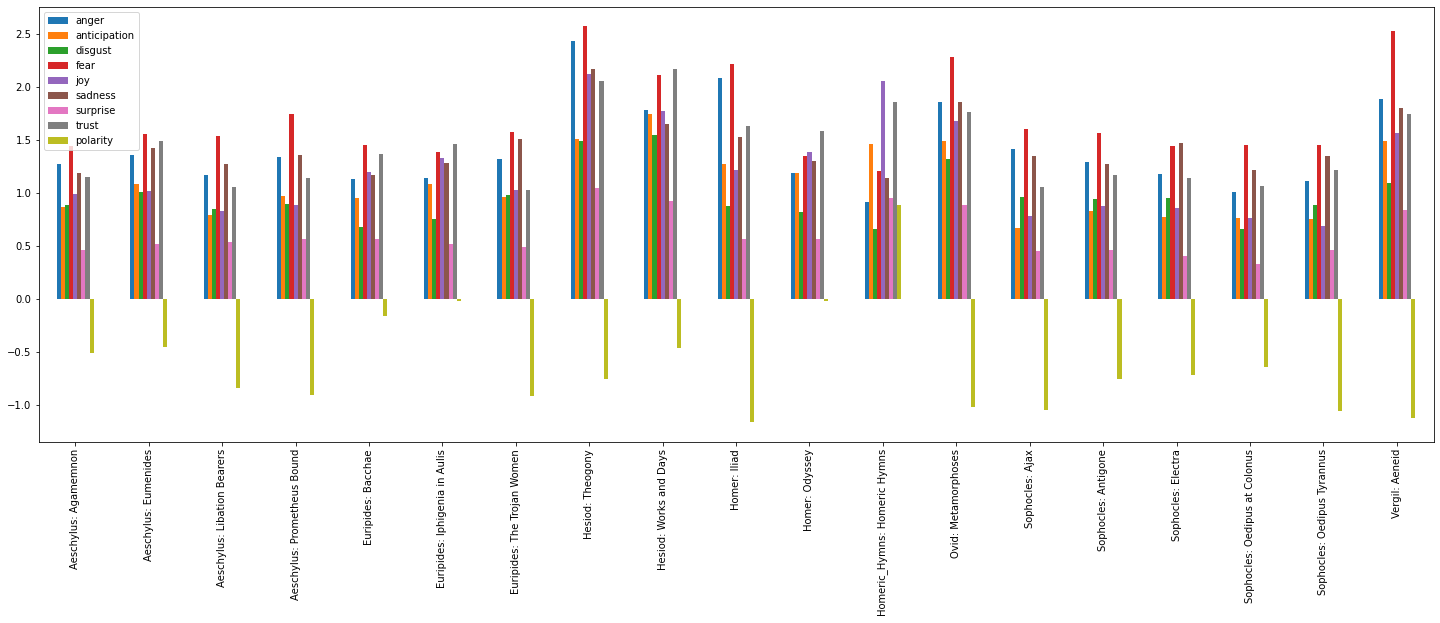

In [33]:
sa.works.plot.bar(figsize=(25, 8))

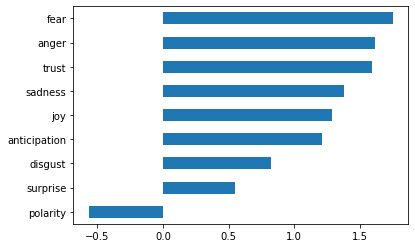

In [34]:
sa.plot_mean_sentiments(author='homer')

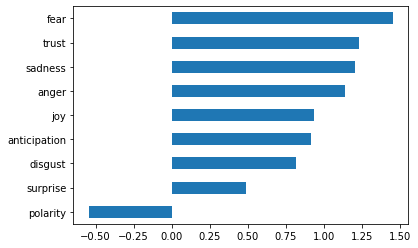

In [35]:
sa.plot_mean_sentiments(author='aeschylus')

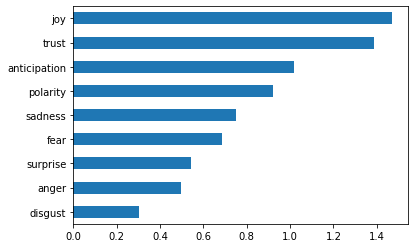

In [36]:
sa.plot_mean_sentiments(work_title='homeric hymns')

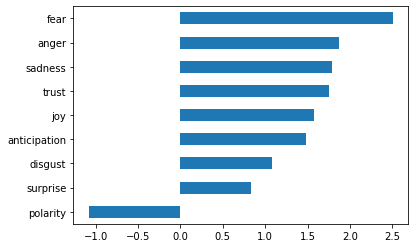

In [37]:
sa.plot_mean_sentiments(work_title="aeneid")

### Chapter table

Cells here are colored based on sentiment value in each chapter. Darker colors indicate more intense emotion for a particular column.

In [38]:
sa.get_chapter_table(work_title="iliad").style.background_gradient(cmap="YlGn")

## Saving Tables

In [39]:
# # Make output directories if they don't already exist
# save_dirs = ['corpus', 'pca', 'topic-model', 'word-embeddings', 'sentiment-analysis']
# for d in save_dirs:
#     d_path = os.path.join(output_dir, d)
#     try:
#         os.mkdir(d_path)
#     except FileExistsError:
#         continue

# # Save corpus tables
# corp.save_tables(os.path.join(output_dir, 'corpus'))

# # Save PCA tables
# pca_dir = os.path.join(output_dir, 'pca')
# pca.dcm.to_csv(os.path.join(pca_dir, 'DCM.csv'))
# pca.loadings.to_csv(os.path.join(pca_dir, 'LOADINGS.csv'))

# # Save Topic Model tables
# lda_dir = os.path.join(output_dir, 'topic-model')
# lda.theta.to_csv(os.path.join(lda_dir, 'THETA.csv'))
# lda.phi.to_csv(os.path.join(lda_dir, 'PHI.csv'))

# # Save Word Embedding tables
# w2v_dir = os.path.join(output_dir, 'word-embeddings')
# w2v.vectors.to_csv(os.path.join(w2v_dir, 'word2vec-EMBEDDINGS.csv'))

# # Save Sentiment Analysis tables
# sa_dir = os.path.join(output_dir, 'sentiment-analysis')
# sa.vocab.to_csv(os.path.join(sa_dir, 'VOCAB-sentiment.csv'))
# sa.bow.to_csv(os.path.join(sa_dir, 'DOC-sentiment.csv'))